# Анализ данных интернет-магазина. A/B-тесты

План работы:
1. Изучить [общую информацию о датафреймах в части 1](#a) и [части 2](#b): пропуски, типы данных, некорректные названия столбцов.
2. Найти и обработать пропуски в данных, если необходимо.
3. Поменять типы данных, где необходимо.
4. Проверить наличие явных и неявных дубликатов, обработать значения.

5. Приоритизировать гипотезы из датафрейма, применив фреймворки [ICE](#c) и [RICE](#d).
6. Выявить [изменения и причины изменений](#e) в оценке приоритетности гипотез двумя разными фреймворками.

7. С помощью графиков, данных о кумулятивных [выручке](#f), [среднем чеке](#g), [среднем количестве заказов](#h), оценить стабильность метрик.
8. Выявить аномальные значения [количества](#i) и [стоимости заказов](#j).
9. Определить границу значений [количества](#i) и [стоимости заказов](#j) для аномальных пользователей.

10. На основе "сырых" данных рассчитать статистическую значимость различий между группами [по среднему количеству заказов на посетителя](#k), [среднему чеку заказа](#l).
11. Очистить данные от аномальных значений для дальнейшего сравнения.
12. На основе "очищенных" данных заново рассчитать значимость различий [по среднему количеству заказов на посетителя](#m), [среднему чеку заказа](#n).
13. Сравнить значения статистической значимости "сырых" и "очищенных" данных.

14. Перепроверить работспособность кода и сформулировать [общий вывод о дальнейшем ходе a/b-теста](#o).   

### Подготовка данных

<a id='first'></a>

In [1]:
#импорт библиотек 

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
              pd.read_csv('/datasets/orders.csv'),
              pd.read_csv('/datasets/visitors.csv'))

In [3]:
#функция для предобработки данных

def first_processing(df):
    info = df.info(),
    head = df.head(),
    duplicates=df.duplicated().sum(),
    df.columns = [x.lower() for x in df.columns]
    return info, print('Дубликатов -',duplicates), head

## Часть 1. Приоритизация гипотез

In [4]:
pd.options.display.max_colwidth = 400

#для отображения текста гипотез полностью

#### Предобработка hypothesis

<a id='a'></a>

In [5]:
first_processing(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Дубликатов - (0,)


((None,),
 None,
 (                                                                                                     Hypothesis  \
  0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
  1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
  2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
  3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
  4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   
  
     Reach  Impact  Confidence  Efforts  
  0      3      10           8        6  
  1      2       5           4       10  
  2      8       3           7        3  
  3      8       3           3        8  
  4      3       1           1        1  ,))

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Выводы по hypothesis:**\
Всего в датафрейме 9 записей по количеству гипотез.\
Пропуски отсутствуют.\
Типы данных в столбцах корректны.\
Дубликаты и аномальные значения отсутствуют.

#### Приоритизация гипотез ICE

<a id='c'></a>

In [8]:
hypothesis['ice']=(hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [9]:
a=hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)
a

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


<BarContainer object of 9 artists>

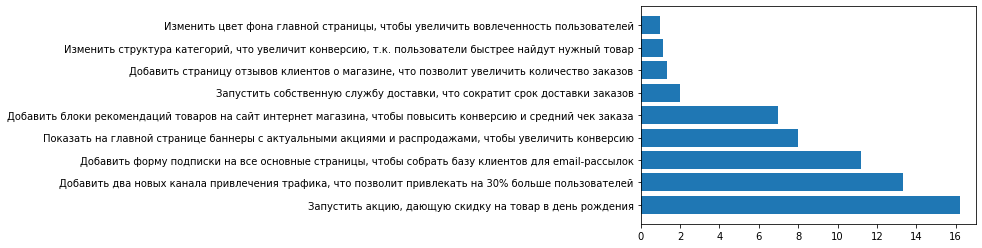

In [10]:
plt.barh(a['hypothesis'],a['ice'])

**Выводы по приоритизации методом ICE:**\
Согласно результатам оценки параметров ICE, наиболее перспективные гипотезы 9, 1 и 8.\
Наименее перспективные - 6, 4 и 5.

#### Приоритизация гипотез RICE

<a id='d'></a>

In [11]:
hypothesis['rice']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [12]:
b=hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)
b

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<BarContainer object of 9 artists>

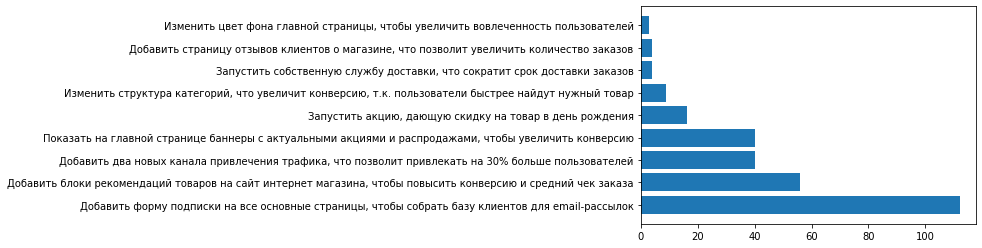

In [13]:
plt.barh(b['hypothesis'],b['rice'])

**Выводы по приоритизации методом RICE:**\
Согласно результатам оценки параметров RICE, наиболее перспективные гипотезы 8, 3, 1 и 7.\
Наименее перспективные - 2, 6 и 5.

### Общий вывод по гипотезам

<a id='e'></a>

По оценкам фреймворка приоритизации *ICE* наиболее важные для проверки гипотезы *9, 1 и 8* (с небольшим отрывом в оценках друг от друга), однако, если принимать во внимание охват нового функционала и оценивать важность гипотез фреймворком *RICE*, то наиболее перспективными становятся *8, 3, 1 и 7*(оценка гипотезы 8 сильно выше остальных).\
И в ICE, и в RICE особенно выделяется гипотеза 8 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' также стоит обратить внимание на гипотезу 1 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'.\
\
Судя по оценкам в обеих фреймфорках, наименее перспективными (с небольшим отличием в оценках) можно считать гипотезы 6 и 5.\
Гипотеза 4 не слишком перспективна с точки зрения ICE, но за счет популярности такого функционала у пользователей заслуживает возможного проведения тестов. А гипотеза 2, хотя не обладает большим охватом, но выигрывает по другим параметрам.

## Часть 2. Анализ A/B-теста

### Предобработка результатов a/b-теста

<a id='b'></a>

#### Предобработка orders

In [14]:
first_processing(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Дубликатов - (0,)


((None,),
 None,
 (   transactionId   visitorId        date  revenue group
  0     3667963787  3312258926  2019-08-15     1650     B
  1     2804400009  3642806036  2019-08-15      730     B
  2     2961555356  4069496402  2019-08-15      400     A
  3     3797467345  1196621759  2019-08-15     9759     B
  4     2282983706  2322279887  2019-08-15     2308     B,))

In [15]:
orders['date'] = orders['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [16]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [17]:
print(orders['revenue'].max())
orders['revenue'].min()

1294500


50

In [18]:
print(orders['date'].max())
orders['date'].min()

2019-08-31 00:00:00


Timestamp('2019-08-01 00:00:00')

In [19]:
groupA = orders[orders['group']=='A']['visitorid'].unique()
groupB = orders[orders['group']=='B']['visitorid'].unique()

In [20]:
def returnMatches(a, b):
    matches = []
    for i in a:
        if i in b:
            matches.append(i)
    return matches

#функция для поиска пользователей попавших в обе группы

In [21]:
matches = returnMatches(groupA, groupB)
len(matches)

58

In [22]:
orders = orders[ ~ orders['visitorid']. isin (matches)]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


**Выводы по orders:**\
Всего в датафрейме 1197 записей по количеству заказов с 1 по 31 августа 2019 года.\
Содержит уникальный номер заказа, номер пользователя, дату оформления заказа, выручка и группа a/b теста.\
Пропуски отсутствуют.\
Тип данных в столбце date изменен на datetime.\
Дубликаты отсутствуют.\
\
58 пользователей попало в обе группы a/b теста, так как их количество составляет около 5% от общего количества данных, было решено убрать строки с повторяющимся visitor id.

#### Предобработка visitors

In [23]:
first_processing(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Дубликатов - (0,)


((None,),
 None,
 (         date group  visitors
  0  2019-08-01     A       719
  1  2019-08-02     A       619
  2  2019-08-03     A       507
  3  2019-08-04     A       717
  4  2019-08-05     A       756,))

In [24]:
visitors['date'] = visitors['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [25]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

In [26]:
print(visitors['visitors'].max())
visitors['visitors'].min()

770


361

In [27]:
print(visitors['date'].max())
visitors['date'].min()

2019-08-31 00:00:00


Timestamp('2019-08-01 00:00:00')

**Выводы по visitors:**\
Всего в датафрейме 62 записи - данные о количестве посетителей сайта по группам с 1 по 31 августа 2019 года.\
Содержит даты, группу a/b теста (50/50) и количество посетителей.\
Пропуски отсутствуют.\
Тип данных в столбце date изменен на datetime.\
Дубликаты отсутствуют.

### Анализ стабильности кумулятивных метрик

#### Кумулятивная выручка по группам

<a id='f'></a>

In [28]:
dates_groups = orders[['date','group']].drop_duplicates()
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [29]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


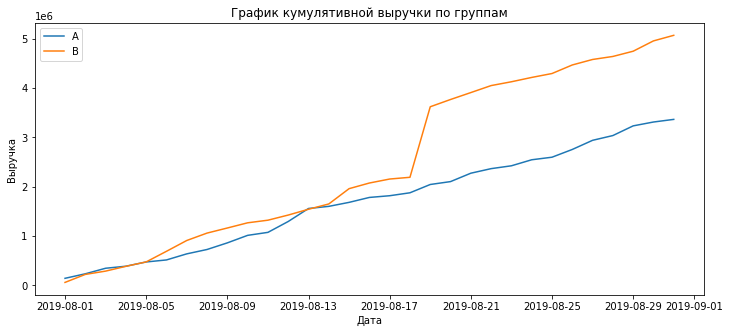

In [30]:
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,5))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')

plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')

plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам')
plt.show()

**Выводы:**\
    Выручка практически равномерно растет на протяжении всего проведения теста.\
    \
    Общая тенденция - показатели группы A стабильно ниже показателей группы B.\
    \
    В самом начале теста показатели обеих групп растут практически одинаково, однако, приблизительно с 5-го августа рост показателей группы B более активный, особенно значимая разница наблюдается 18-19 августа - выброс значений. Вероятно в этот день пользователем из группы B был совершен аномально-дорогой заказ или пользователями сделано аномально много заказов.

#### Кумулятивный средний чек по группам

<a id='g'></a>

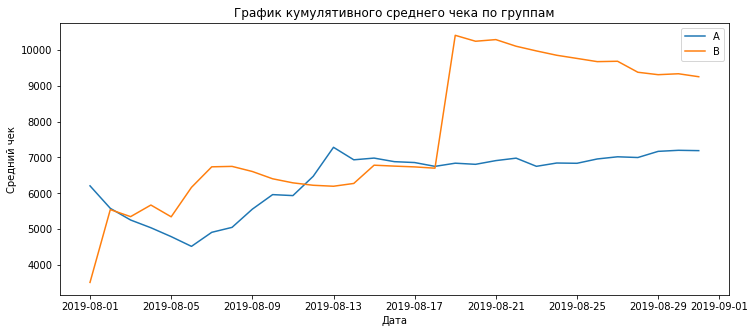

In [31]:
plt.figure(figsize=(12,5))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.show()

**Выводы:**\
Показатели среднего чека не равномерны: то растут, то падают.

По данным графика кумулятивного среднего чека по группам, тенденция к сближению показателей двух групп наблюдается в середине месяца, однако, резкий выброс меняет ситуацию.
Средний чек пользователей группы A с этого этапа начинает очень плавно и практически равномерно расти, а средний чек группы B резко вырастает (такой всплеск наблюдаем и на графике выручки), затем постепенно падает. Падение вероятно связано с предшествующим ему аномально-дорогим заказом.

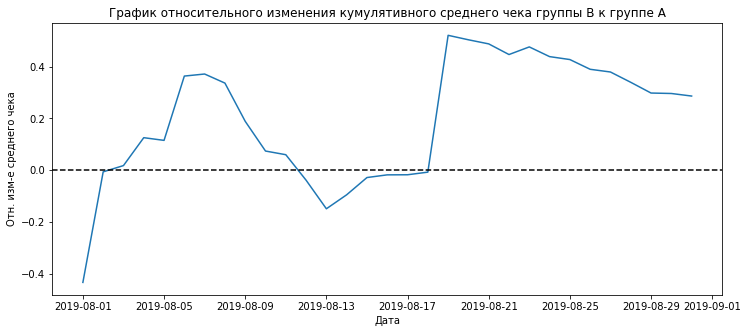

In [32]:
merged_cumulative_revenue = cumulative_revenueA.merge(cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 

plt.xlabel('Дата')
plt.ylabel('Отн. изм-е среднего чека')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

**Выводы:**\
График относительного изменения кумулятивного среднего чека группы B к группе A также показывает резкие скачки и падения данных, что вероятно указывает на большое количество или большое значение аномальных данных.

#### Кумулятивное среднее количества заказов на пользователя по группам

<a id='h'></a>

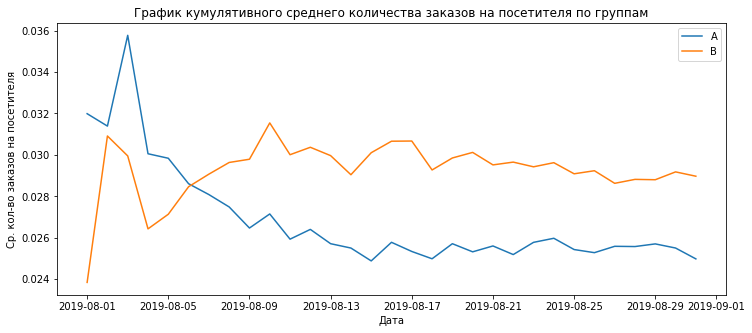

In [33]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

cumulative_dataA = cumulative_data[cumulative_data['group']=='A']

cumulative_dataB = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(12,5))
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Ср. кол-во заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.show()

**Выводы:**\
Показатели конверсии также не равномерны.\
Начиная с 10-го августа, количество заказов группы B стабильно выше заказов группы A.\
Вероятно такой резкий скачок связан с аномально большим количеством заказов 9-10 августа (на графиках выручки и среднего чека резких изменений в эти даты не наблюдается).

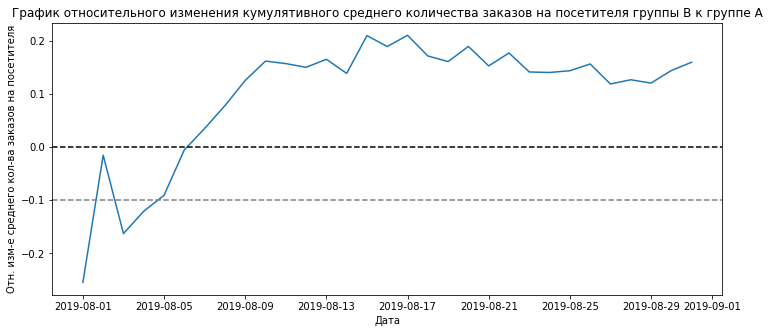

In [34]:
merged_cumulative_conversions = cumulative_dataA[['date','conversion']].merge(cumulative_dataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отн. изм-е среднего кол-ва заказов на посетителя')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

**Выводы:**\
График относительного изменения кумулятивной конверсии группы B к группе A также показывает резкие скачки и падения данных, что вероятно указывает на большое количество или большое значение аномальных данных.\
При этом практически с начала проведения теста, изменение кумулятивного количества заказов на посетителя B к A  растет.

### Анализ выбросов и всплесков

#### Количество заказов по пользователям

<a id='i'></a>

In [35]:
orders_per_user = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

orders_per_user.columns = ['user_id', 'orders']

orders_per_user.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


In [36]:
orders_per_user['orders'].value_counts()

1    937
2     29
3      7
Name: orders, dtype: int64

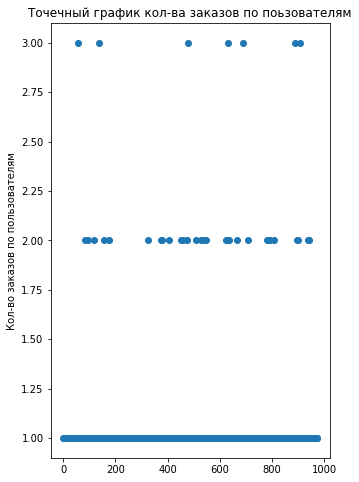

In [37]:
x_values = pd.Series(range(0,len(orders_per_user)))

plt.figure(figsize=(5,8))
plt.scatter(x_values, orders_per_user['orders']) 
plt.ylabel('Кол-во заказов по пользователям')
plt.title('Точечный график кол-ва заказов по поьзователям')
plt.show()

In [38]:
np.percentile(orders_per_user['orders'], [95, 99])

array([1., 2.])

**Выводы:**\
Основная масса пользователей *(99%)* делает 1-2 заказа, однако, как и предполагалось ранее, существуют и такие пользователи, которые совершили 3 заказа.\
\
Границей аномальных значений будем считать 1 заказ, всего 5% пользователей сделали больше заказов.

#### Стоимость заказов по пользователям

<a id='j'></a>

In [39]:
cost_per_user = (
    orders.groupby('visitorid', as_index=False)
    .agg({'revenue': 'sum'})
)

cost_per_user.columns = ['user_id', 'cost']

cost_per_user.sort_values(by='cost', ascending=False).head(10)

,user_id,cost
440,1920142716,1294500
477,2108080724,202740
300,1307669133,92550
202,888512513,86620
176,759473111,72000
938,4133034833,67990
687,2988190573,67190
267,1164614297,66350
25,148427295,65710
200,887908475,60450


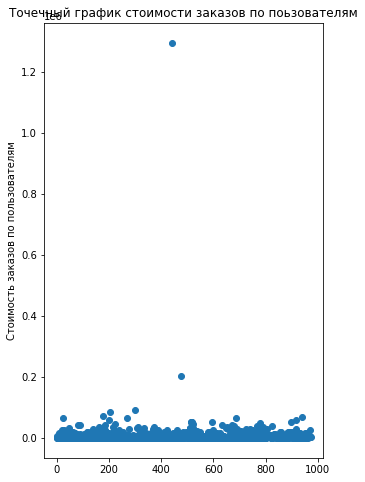

In [40]:
x_values = pd.Series(range(0,len(cost_per_user)))

plt.figure(figsize=(5,8))
plt.scatter(x_values, cost_per_user['cost']) 
plt.ylabel('Стоимость заказов по пользователям')
plt.title('Точечный график стоимости заказов по поьзователям')
plt.show()

In [41]:
np.percentile(cost_per_user['cost'], [95, 99])

array([28910., 59082.])

**Выводы:**\
В стоимости довольно много выбросов, один особенно значительный - аномально-дорогой заказ.\ 
Большинство пользователей *(95%)* не тратит больше 29 тысяч денежных единиц на заказ, однако, как и предполагалось ранее, пользователями совершались значительно более дорогие заказы.\
\
Границей аномальных значений по стоимости будем считать 29 000, поскольку 95% пользователей не тратили больше этой суммы на заказы.

### Статистическая значимость различий между группами. "Сырые" данные

#### Среднее количество заказов на посетителя

<a id='k'></a>

In [42]:
visitorsA_day = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsA_day.columns = ['date', 'visitors_per_dateA']

#количество посетителей группы A ежедневно

In [43]:
visitorsA_cummulative = visitorsA_day.apply(
    lambda x: visitorsA_day[visitorsA_day['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateA': 'sum'}
    ),
    axis=1,
)
visitorsA_cummulative.columns = ['date', 'visitorsA_cummulative']

#кумулятивное количество посетителей группы A

In [44]:
visitorsB_day = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsB_day.columns = ['date', 'visitors_per_dateB']

#количество посетителей группы B ежедневно

In [45]:
visitorsB_cummulative = visitorsB_day.apply(
    lambda x: visitorsB_day[visitorsB_day['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateB': 'sum'}
    ),
    axis=1,
)
visitorsB_cummulative.columns = ['date', 'visitorsB_cummulative']

#кумулятивное количество посетителей группы A

In [46]:
ordersA_day = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersA_day.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

ordersA_cummulative = ordersA_day.apply(
    lambda x: ordersA_day[ordersA_day['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateA': 'sum', 'revenue_per_dateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersA_cummulative.columns = [
    'date',
    'ordersA_cummulative',
    'revenueA_cummulative',
]

#кумулятивное количество заказов и выручки группы A

In [47]:
ordersB_day = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersB_day.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

ordersB_cummulative = ordersB_day.apply(
    lambda x: ordersB_day[ordersB_day['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateB': 'sum', 'revenue_per_dateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersB_cummulative.columns = [
    'date',
    'ordersB_cummulative',
    'revenueB_cummulative',
]

#кумулятивное количество заказов и выручки группы B

In [48]:
data_merged = (
    ordersA_day.merge(
        ordersB_day, left_on='date', right_on='date', how='left'
    )
    .merge(ordersA_cummulative, left_on='date', right_on='date', how='left')
    .merge(ordersB_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsA_day, left_on='date', right_on='date', how='left')
    .merge(visitorsB_day, left_on='date', right_on='date', how='left')
    .merge(visitorsA_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsB_cummulative, left_on='date', right_on='date', how='left')
)

data_merged.head(5)

#таблица, в которой объединены данные по 2-м группам: дата, количество заказов (в день и кумулятивное), 
#выручка (в день и кумулятивная),количество посетителей (в день и кумулятивное)

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,ordersA_cummulative,revenueA_cummulative,ordersB_cummulative,revenueB_cummulative,visitors_per_dateA,visitors_per_dateB,visitorsA_cummulative,visitorsB_cummulative
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [49]:
orders_per_userA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_per_userA.columns = ['user_id', 'orders']

orders_per_userB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_per_userB.columns = ['user_id', 'orders'] 

#количество заказов на каждого пользователя для групп A и B

In [50]:
sampleA = pd.concat([orders_per_userA['orders'],pd.Series(0, index=np.arange(data_merged['visitors_per_dateA'].sum() - len(orders_per_userA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([orders_per_userB['orders'],pd.Series(0, index=np.arange(data_merged['visitors_per_dateB'].sum() - len(orders_per_userB['orders'])), name='orders')],axis=0)

#поиск пользователей совершивших хотя бы 1 заказ в обеих группах

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18736, dtype: int64

H0: статистически значимых различий в среднем количестве заказов на посетителя между группами А и В по «сырым» данным нет.\
H1: статистически значимые различия в среднем количестве заказов на посетителя между группами А и В по «сырым» данным есть.

In [52]:
p_value1 = "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])
difference1 = "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)

print('p-value =',p_value1)
print('разница между сегментами =',difference1)

p-value = 0.011
разница между сегментами = 0.160


**Выводы:**

In [53]:
pd.DataFrame(data=[['Средний чек заказа', p_value1, difference1]],
            columns=['Параметр','p-value','Разница между сегментами'])

,Параметр,p-value,Разница между сегментами
0,Средний чек заказа,0.011,0.160


*Количество заказов\посетитель*: p-value, рассчитанное по "сырым" данным, меньше уровня значимости 5%, значит, в данном случае, отвергаем нулевую гипотезу об отсуствии отличий в среднем количестве заказов на одного посетителя у групп A и B. Показатели группы B больше на 16% и такое отличие является статистически значимым.

#### Средний чек заказа

<a id='l'></a>

H0: статистически значимых различий в среднем чеке заказа между группами А и В по «сырым» данным нет.\
H1: статистически значимые различия в среднем чеке заказа между группами А и В по «сырым» данным есть.

In [54]:
p_value2 = '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])
difference2 = '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

print('p-value =', p_value2)
print('разница между сегментами =', difference2)

p-value = 0.829
разница между сегментами = 0.287


**Выводы:**

In [55]:
pd.DataFrame(data=[['Среднее кол-во заказов на посетителя', p_value2, difference2]],
            columns=['Параметр','p-value','Разница между сегментами'])

,Параметр,p-value,Разница между сегментами
0,Среднее кол-во заказов на посетителя,0.829,0.287


*Средний чек заказа*: p-value, рассчитанное по "сырым" данным, ощутимо выше уровня значимости 5%, значит, в данном случае, принимаем нулевую гипотезу об отсутсвии отличий в среднем чеке заказа у пользователей из групп A и B. Показатели группы B выше на 29%, отличие не является статистически значимым.

### Статистическая значимость различий между группами. "Очищенные" данные

#### Среднее количество заказов на посетителя

<a id='m'></a>

In [56]:
many_orders = pd.concat(
    [
        orders_per_userA[orders_per_userA['orders'] > np.percentile(orders_per_user['orders'], 95)]['user_id'],
        orders_per_userB[orders_per_userB['orders'] > np.percentile(orders_per_user['orders'], 95)]['user_id'],
    ],
    axis=0,
) #пользователи с аномальным количество заказов

expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorid']
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
) #пользователи с аномально дорогими заказами

abnormal_users.shape[0] #количество аномальных пользователей

86

In [57]:
sampleA_filtered = pd.concat(
    [
        orders_per_userA[
            np.logical_not(orders_per_userA['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_merged['visitors_per_dateA'].sum() - len(orders_per_userA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18697, dtype: int64

In [57]:
sampleB_filtered = pd.concat(
    [
        orders_per_userB[
            np.logical_not(orders_per_userB['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_merged['visitors_per_dateB'].sum() - len(orders_per_userB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

H0: статистически значимых различий в среднем количестве заказов на посетителя между группами А и В по «очищенным» данным нет.\
H1: статистически значимые различия в среднем количестве заказов на посетителя между группами А и В по «очищенным» данным есть.

In [58]:
p_value3='{0:.3f}'.format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1])
difference3='{0:.3f}'.format(sampleB_filtered.mean()/sampleA_filtered.mean()-1)

print('p-value =', p_value3)
print('разница между сегментами =', difference3)

p-value = 0.016
разница между сегментами = 0.174


**Вывод:**

In [59]:
pd.DataFrame(data=[['Среднее кол-во заказов на посетителя', p_value3, difference3]],
            columns=['Параметр','p-value','Разница между сегментами'])

,Параметр,p-value,Разница между сегментами
0,Среднее кол-во заказов на посетителя,0.016,0.174


*Количество заказов\посетитель*: p-value, рассчитанное по "очищенным" данным, (также как и в ситуации с ["сырыми" данными](#k)) меньше уровня значимости 5%, - значит, мы отвергаем нулевую гипотезу об отсутствии отличий в среднем количестве заказов на посетителя. Показатели отфильтрованной группы B больше на 17% и являются статистически значимыми.

#### Средний чек заказа

<a id='n'></a>

H0: статистически значимых различий в среднем чеке заказа между группами А и В по «очищенным» данным нет.\
H1: статистически значимые различия в среднем чеке заказа между группами А и В по «очищенным» данным есть.

In [60]:
p_value4= '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
difference4="{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )

print('p-value =',
    p_value4
)

print('разница между сегментами =',
    difference4
)

p-value = 0.727
разница между сегментами = -0.034


**Вывод:**

In [61]:
pd.DataFrame(data=[['Средний чек заказа',p_value4, difference4]],
            columns=['Параметр','p-value','Разница между сегментами'])

,Параметр,p-value,Разница между сегментами
0,Средний чек заказа,0.727,-0.034


*Средний чек заказа*: p-value, рассчитанное по "сырым" данным, [по-прежнему](#l) ощутимо выше уровня значимости 5%, значит, в данном случае, нулевую гипотезу об отсутсвии отличий в среднем чеке заказа у пользователей из групп A и B принимаем. Почистив данные, мы видим, что группа B проигрывает на 3%, разница не является статистически значимой.

#### Вывод по A/B-тесту

Исходя из полученных в настоящий момент данных, на данном этапе результаты A/B-теста:
- Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по сырым данным, так и по обработанным.
- По среднему чеку статистически значимое различие между группами отсутствует.
- По неравномерному графику относительного изменения среднего чека (группы B к A) выводы сделать невозможно, но по графику относительного изменения количества заказов (группы B к A) группа B показывает более высокие показатели.\
\
Тест рекомендуется завершить.

### Общий вывод

<a id='o'></a>

В ходе исследования были рассмотрены **данные крупного интернет-магазина с 1 по 31 августа 2024 года**: список гипотез для увеличения выручки, результаты проведённого ранее A/B-теста.



Из 9-ти данных гипотез, по оценкам фреймворков приоритизации  ICE и RICE **наиболее важными** для тестирования можно считать *гипотезу 8 - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'* и, чуть менее важную, *гипотезу 1 - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'*.\
\
**Наименее приоритетными** показали себя *гипотеза 5 - 'Изменить цвет фона главной страницы, чтобы увеличить вовлечённость пользователей'* и *гипотеза 6 - 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов'*.\
\
Приоритетность гипотез хорошо видна на графиках [ICE](#c) и [RICE](#d).

Из первичного анализа датафрейма с информацией о заказах, важно отметить, что 58 пользователей попало в обе группы A/B теста. Поскольку их количество составляет около 5% от общего количества данных, было решено убрать из анализа данные о повторяющихся пользователях. В итоге в таблице осталиь 1016 записей.

Анализ стабильности кумулятивных метрик показал:
1. **Кумулятивная выручка** практически равномерно растет на протяжении всего проведения теста. Показатели группы группы B, на данный момент, выше показателей группы A. Резкий всплеск у группы B - 18-19 августа - скорее всего пользователем был совершен аномально-дорогой заказ или большое количество заказов.
2. **Кумулятивный средний чек** то растет, то падает, очень неравномерен. Особенно резкий всплеск также 18-19 августа. Выводы касательно лидерства той или иной группы делать пока не стоит, слишком неравномерные данные. Вероятно большое количество аномальных неоднородных значений.
3. **Кумулятивное среднее количество заказов на посетителя** также неравномерно. В начале лидирует группа A, но к 10-му числу читуация меняется и показатели группы B - хотя не равномерны - но стабильно выше показателей группы A.

Анализ **выбросов значений в количестве заказов по пользователям и стоимости заказов по пользователям** показал:\
99% пользователей делают до 2-ух заказов. Границей аномальных значений выберем 1 заказ - всего 5% пользователей совершали больше одного заказа.\
99% пользователей совершают заказы до 58 000. Границей аномальных значений выберем 29 000 - всего 5% пользователей совершали более дорогие заказы.

Согласно результатам **рассчёта статистически-значимых различий**:
1. На данном этапе при работе с сырыми данными, и с данными очищенными от выбросов отвергается нулевая гипотеза об отсуствии отличий между группами A и B *в среднем количестве заказов* на 1-го посетителя.

2. При работе с сырыми данными, и с данными очищенными от выбросов *принимаем нулевую гипотезу об отсутствии отличий средних чеков заказа* у двух групп A и B.

Отсюда, можем сделать вывод по результатам A/B-теста:
- Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по сырым данным, так и по обработанным.
- По среднему чеку статистически значимое различие между группами отсутствует.
- По неравномерному [графику относительного изменения среднего чека (группы B к A)](#g) выводы сделать невозможно, но по [графику относительного изменения количества заказов (группы B к A)](#h) **группа B показывает более высокие показатели**.\
\
Тест можно считать успешным, его **рекомендуется завершить.**